In [74]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [75]:
config={
    'BatchSize':128,
    'seed':42,
    'n_epochs' : 100,
    'lr' : 0.001,
    'patience':7
}

torch.cuda.manual_seed_all(config['seed'])
torch.manual_seed(config['seed'])

#ここで固定しておかないとgenesisモデルで毎回違う乱数が生成される

In [76]:

trainval_dataset = datasets.CIFAR10('data/cifar10', train=True,download=True,transform=transforms.ToTensor())

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor()])

trainval_dataset = datasets.CIFAR10('data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000],generator=torch.Generator().manual_seed(config['seed']))

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

print("Train data number:{}, Valid data number: {}".format(len(train_dataset), len(val_dataset)))

Files already downloaded and verified
Train data number:40000, Valid data number: 10000


In [77]:

class Bio_genesis(nn.Module):
    def __init__(self,ratio=0.5,path='checkpoint/gradually_increase.pt',patience=7,verbose=False):
        super().__init__()
        self.ratio=ratio
        self.mask=True
        self.patience=patience
        self.best_acc=None
        self.path=path
        self.counter=0
        self.__increase=False
        self.verbose=verbose
        self.val_acc_max= -np.Inf
    @property
    def increase(self):
        return self.__increase
    
    def update(self,val_acc,model):
        if self.best_acc is None:
            self.best_acc=val_acc
            self.save_checkpoint(model,val_acc)
        elif val_acc < self.best_acc:
            self.counter+=1
            if self.verbose and self.counter!=self.patience:
                print(f'NeuroGensisCounter: {self.counter} out of {self.patience}')
            #if self.counter >= self.patience:
                #self.__increase = True
            if self.counter==self.patience:
                self.ratio -= 0.1
                self.counter=0
                print('The number of neuron decreased !!')
                if self.ratio<0:
                    self.__increase=True
        else:
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
            self.counter = 0

    def save_checkpoint(self,model,val_acc):
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc     

    def load_checkpoint(self,model):
        if self.verbose:
            print(f'Loading model from last checkpoint with validation accuracy {self.val_acc_max:.6f}')
        model.load_state_dict(torch.load(self.path))
        return model    
    

    def forward(self,x):
        if self.training:
                self.mask=torch.rand(*x.size()) > self.ratio
                return x * self.mask.to(x.device)
        else:
            return x * (1.0 - self.ratio)

genesis=Bio_genesis(patience=config['patience'],verbose=True)



In [78]:

class NeurogenesisModel(nn.Module):
    def __init__(self):
        super(NeurogenesisModel, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 3)       # 32x32x3 -> 30x30x32
        self.bn1=nn.BatchNorm2d(32)
        self.av1=nn.ReLU()
        self.pool1=nn.AvgPool2d(2)                  # 30x30x32 -> 15x15x32
        self.conv2=nn.Conv2d(32, 64, 3)             # 15x15x32 -> 13x13x64
        self.bn2=nn.BatchNorm2d(64)
        self.av2=nn.ReLU()
        self.pool2=nn.AvgPool2d(2)                  # 13x13x64 -> 6x6x64
        #self.conv3=nn.Conv2d(64, 128, 3)            # 6x6x64 -> 4x4x128
        #self.bn3=nn.BatchNorm2d(128)
        #self.av3=nn.ReLU()
        #self.pool3=nn.AvgPool2d(2)                  # 4x4x128 -> 2x2x128
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(2304, 256)   
        self.relu=nn.ReLU()
        self.genesis=genesis
        self.fc2=nn.Linear(256, 10)
        #self.fc1 = nn.Linear(input_size, hidden_size)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.av1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.av2(x)
        x=self.pool2(x)     
        #x=self.conv3(x)
        #x=self.bn3(x)
        #x=self.av3(x)
        #x=self.pool3(x)  
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.genesis(x)
        x=self.fc2(x)
        return x

model=NeurogenesisModel()

In [79]:

def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

model.apply(init_weights)

device='cuda'
model.to(device)
optimizer2 = optim.Adam(model.parameters(), lr=config['lr'])
sheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer2,'min',patience=config['patience'],factor=0.5,verbose=True)
loss_function = nn.CrossEntropyLoss() 

- とりあえず学習率が変わるようにコードを組み替える

Validation accuracy increased (-inf --> 0.549200).  Saving model ...
EPOCH: 1, Train [Loss: 1.557, Accuracy: 0.436], Valid [Loss: 1.263, Accuracy: 0.549],ratio:0.500,lr:0.001]

Validation accuracy increased (0.549200 --> 0.613800).  Saving model ...
EPOCH: 2, Train [Loss: 1.258, Accuracy: 0.549], Valid [Loss: 1.099, Accuracy: 0.614],ratio:0.500,lr:0.001]

Validation accuracy increased (0.613800 --> 0.640000).  Saving model ...
EPOCH: 3, Train [Loss: 1.113, Accuracy: 0.604], Valid [Loss: 1.014, Accuracy: 0.640],ratio:0.500,lr:0.001]

Validation accuracy increased (0.640000 --> 0.642700).  Saving model ...
EPOCH: 4, Train [Loss: 1.021, Accuracy: 0.639], Valid [Loss: 1.027, Accuracy: 0.643],ratio:0.500,lr:0.001]

Validation accuracy increased (0.642700 --> 0.650100).  Saving model ...
EPOCH: 5, Train [Loss: 0.957, Accuracy: 0.660], Valid [Loss: 0.999, Accuracy: 0.650],ratio:0.500,lr:0.001]

Validation accuracy increased (0.650100 --> 0.673700).  Saving model ...
EPOCH: 6, Train [Loss: 0.9

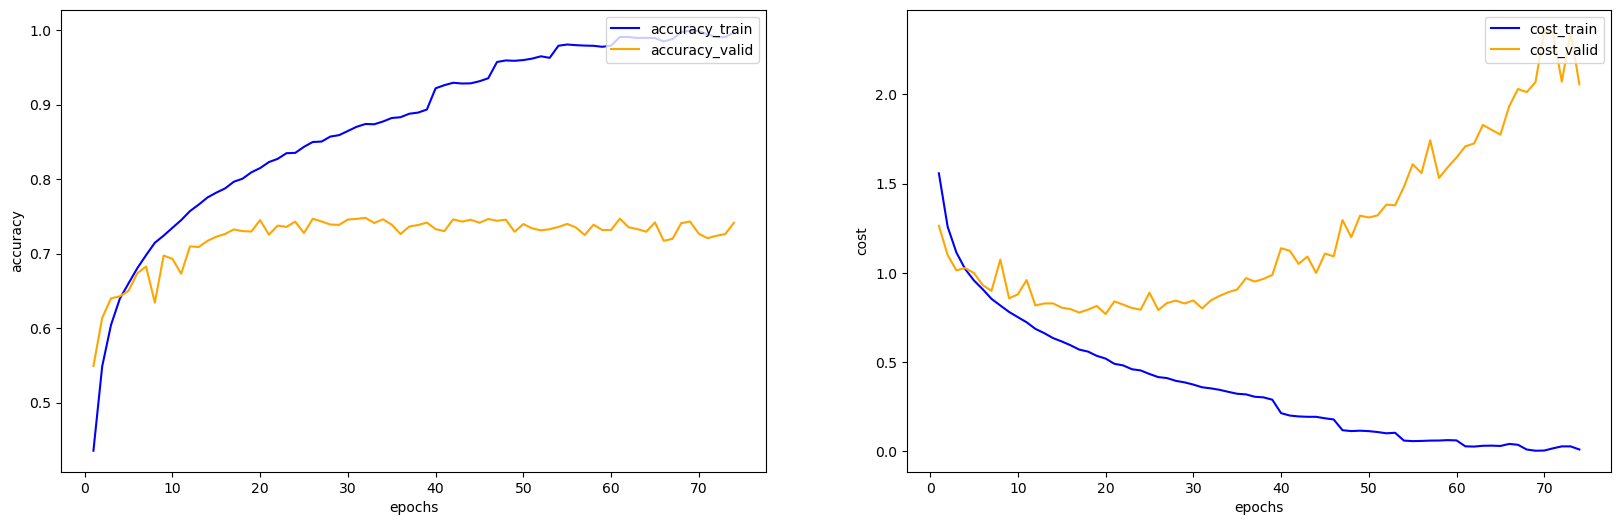

<Figure size 640x480 with 0 Axes>

In [80]:
accuracy_train=[]
cost_train=[]
accuracy_valid=[]
cost_valid=[]

for epoch in range(config['n_epochs']):
    losses_train = []
    losses_valid = []

    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        model.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播


        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新


        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))
    sheduler.step(cost_train[epoch])

    model.eval()
    n_val = 0
    val_acc=0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        val_acc += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    
    accuracy_valid.append(val_acc/n_val)
    cost_valid.append(np.mean(losses_valid))


    genesis.update(val_acc/n_val, model)

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}],ratio:{:.3f},lr:{:.3f}]\n'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        val_acc/n_val,
        genesis.ratio,
        optimizer2.param_groups[0]['lr']
    ))

    if genesis.increase:
        print('Early stopping !')
        break

model = genesis.load_checkpoint(model)

y=len(accuracy_train)

x=np.arange(1,y+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')


plt.show()

plt.savefig('graph/neurogenesis.png')

In [81]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

correct = 0
total = 0
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Files already downloaded and verified
Accuracy of the network on the 10000 test images: 74 %


In [82]:
conv_net2 = nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3 -> 30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32 -> 15x15x32
    nn.Conv2d(32, 64, 3),             # 15x15x32 -> 13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 13x13x64 -> 6x6x64
    #nn.Conv2d(64, 128, 3),            # 6x6x64 -> 4x4x128
    #nn.BatchNorm2d(128),
    #nn.ReLU(),
    #nn.AvgPool2d(2),                  # 4x4x128 -> 2x2x128
    nn.Flatten(),
    nn.Linear(2304, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net2.apply(init_weights)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net2.to(device)
optimizer2 = optim.Adam(conv_net2.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  # nn.ClossEntropyLossは，出力のsoftmax変換と，正解ラベルのone-hot vector化の機能を持っている

In [83]:
for epoch in range(config['n_epochs']):
    losses_train = []
    losses_valid = []

    conv_net2.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net2.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net2.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 1, Train [Loss: 2.083, Accuracy: 0.343], Valid [Loss: 1.542, Accuracy: 0.416]
EPOCH: 2, Train [Loss: 1.315, Accuracy: 0.528], Valid [Loss: 1.376, Accuracy: 0.514]
EPOCH: 3, Train [Loss: 1.093, Accuracy: 0.614], Valid [Loss: 1.254, Accuracy: 0.565]
EPOCH: 4, Train [Loss: 0.950, Accuracy: 0.671], Valid [Loss: 1.329, Accuracy: 0.572]
EPOCH: 5, Train [Loss: 0.861, Accuracy: 0.701], Valid [Loss: 0.944, Accuracy: 0.673]
EPOCH: 6, Train [Loss: 0.785, Accuracy: 0.729], Valid [Loss: 0.971, Accuracy: 0.660]
EPOCH: 7, Train [Loss: 0.721, Accuracy: 0.749], Valid [Loss: 1.079, Accuracy: 0.650]
EPOCH: 8, Train [Loss: 0.676, Accuracy: 0.767], Valid [Loss: 1.135, Accuracy: 0.651]
EPOCH: 9, Train [Loss: 0.631, Accuracy: 0.782], Valid [Loss: 1.040, Accuracy: 0.655]
EPOCH: 10, Train [Loss: 0.585, Accuracy: 0.797], Valid [Loss: 1.066, Accuracy: 0.666]
EPOCH: 11, Train [Loss: 0.553, Accuracy: 0.810], Valid [Loss: 1.028, Accuracy: 0.687]
EPOCH: 12, Train [Loss: 0.517, Accuracy: 0.819], Valid [Loss: 0

In [84]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

correct = 0
total = 0
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = conv_net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 66 %
